**Import all the necessary libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet169

['test', 'train', 'train.csv', 'sample_submission.csv']


Using TensorFlow backend.


**Create the base directory**

In [2]:
base_dir = os.path.join('..', 'input')

**Load the train.csv as Pandas DataFrame**

In [3]:
train_df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


This is a binary classification problem. Therefore, the last layer of the neural network should use "sigmoid" activation

In [4]:
#Let's see how many training data:
print("There are {} training images".format(len(train_df)))

There are 17500 training images


In [5]:
train_images = os.path.join(base_dir, 'train/train')
test_images = os.path.join(base_dir, 'test/test')

print("There are {} images in the train folder.".format(len(os.listdir(train_images))))
print("There are {} images in the test folder.".format(len(os.listdir(test_images))))

There are 17500 images in the train folder.
There are 4000 images in the test folder.


**Process the data**

In [6]:
#create a column in dataframe to store image paths
#let's test the glob function first:
i = 0
for x in glob(os.path.join(train_images,'*.jpg')):
    print(x)
    i += 1
    
    if i == 5:
        break

../input/train/train/028192187883168e2a7621c998dc447a.jpg
../input/train/train/95d2e16da6d3fb55b84f83f25a7dcf2e.jpg
../input/train/train/03fe79948e15465c62c400ad9d9fab13.jpg
../input/train/train/f5fc5cebc8bf22c70240fd42bd3d64e8.jpg
../input/train/train/d8d2f5becda9d56dadf2d64339395807.jpg


Create a dictionary that matches Image ID and Image Path

In [7]:
image_id_path = {os.path.basename(x): x for x in glob(os.path.join(train_images, '*.jpg'))}

Create the column "path":

In [8]:
train_df['path'] = train_df['id'].map(image_id_path.get)

In [9]:
train_df.head()

,id,has_cactus,path
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,../input/train/train/0004be2cfeaba1c0361d39e2b...
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,../input/train/train/000c8a36845c0208e833c79c1...
2,000d1e9a533f62e55c289303b072733d.jpg,1,../input/train/train/000d1e9a533f62e55c289303b...
3,0011485b40695e9138e92d0b3fb55128.jpg,1,../input/train/train/0011485b40695e9138e92d0b3...
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,../input/train/train/0014d7a11e90b62848904c141...


Let load the image pixels to a column named "images"

In [10]:
train_df['images'] = train_df['path'].map(lambda x: np.array(Image.open(x).resize((32,32))))

Normalize the image pixels

In [11]:
train_df['images'] = train_df['images'] / 255

In [12]:
#each image's shape
train_df['images'][0].shape

(32, 32, 3)

**EDA**

Check if there is any null values

In [13]:
train_df.isnull().sum()

id            0
has_cactus    0
path          0
images        0
dtype: int64

Check data balance

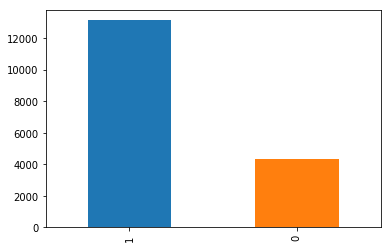

In [14]:
train_df['has_cactus'].value_counts().plot(kind='bar')

There are more than half of the images that contain cactus. The dataset is not balanced. 

Visualize some sample images

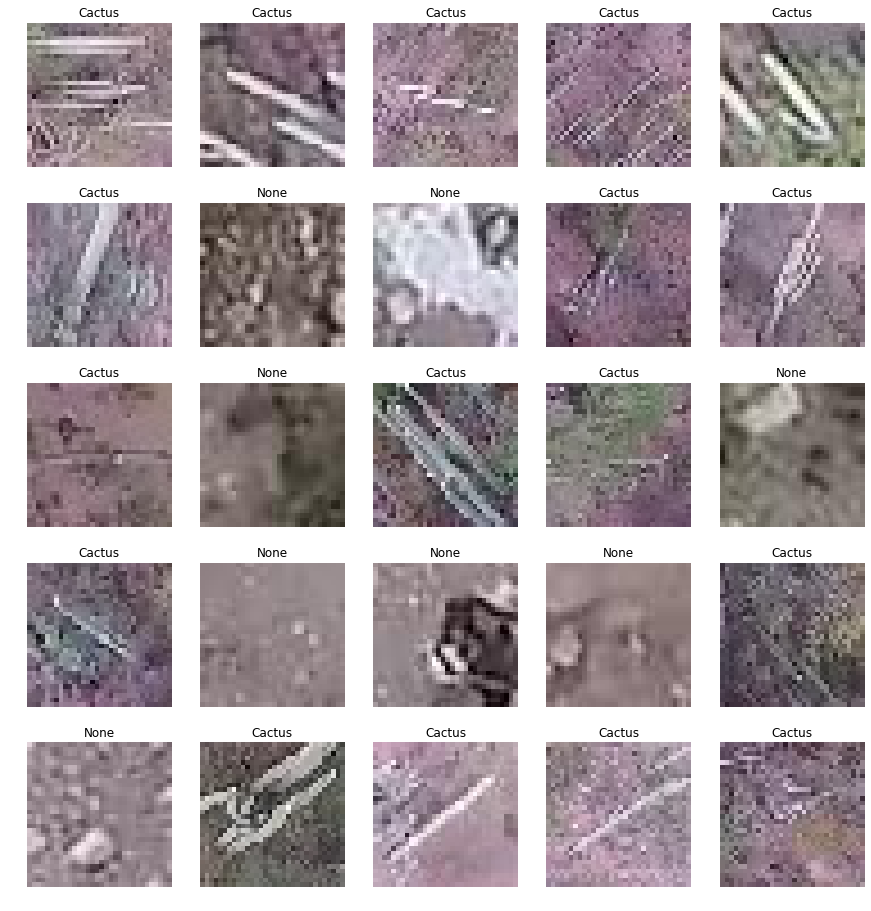

In [15]:
n_rows = 5
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,16))

i = 0
for each_row in ax:
    
    for each_row_col in each_row:
        each_row_col.imshow(train_df['images'][i])
        
        if train_df['has_cactus'][i] == 1:
            each_row_col.set_title('Cactus')
        else:
            each_row_col.set_title('None')
        
        each_row_col.axis('off')
        i += 1

Intuitively after looking at the sample images, the ones that contain cactus have columnar shapes or "line" shapes. We'll train a model to recognize such vital features. 

**Let's have the test data available as well**

In [16]:
test_df = pd.read_csv(os.path.join(base_dir,'sample_submission.csv'))
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [17]:
test_imageid_path = {os.path.basename(x):x for x in glob(os.path.join(test_images,'*.jpg'))}

In [18]:
test_df['path'] = test_df['id'].map(test_imageid_path.get)

In [19]:
test_df['images'] = test_df['path'].map(lambda x: np.array(Image.open(x)))

In [20]:
test_df.head()

,id,has_cactus,path,images
0,000940378805c44108d287872b2f04ce.jpg,0.5,../input/test/test/000940378805c44108d287872b2...,"[[[57, 59, 54], [54, 56, 51], [27, 29, 24], [4..."
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5,../input/test/test/0017242f54ececa4512b4d7937d...,"[[[80, 71, 72], [85, 76, 77], [84, 76, 74], [9..."
2,001ee6d8564003107853118ab87df407.jpg,0.5,../input/test/test/001ee6d8564003107853118ab87...,"[[[97, 92, 73], [120, 117, 98], [141, 138, 119..."
3,002e175c3c1e060769475f52182583d0.jpg,0.5,../input/test/test/002e175c3c1e060769475f52182...,"[[[112, 98, 98], [110, 96, 96], [117, 103, 103..."
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5,../input/test/test/0036e44a7e8f7218e9bc7bf8137...,"[[[87, 80, 87], [90, 80, 88], [97, 87, 95], [9..."


In [21]:
#sample one test image
print("test image's shape: ", test_df['images'][0].shape)

test image's shape:  (32, 32, 3)


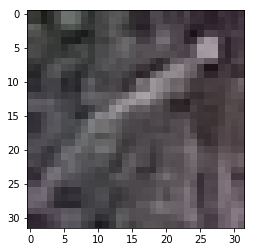

In [22]:
plt.imshow(test_df['images'][0])

In [23]:
#check if there is null values in test dataframe:
test_df.isnull().sum()

id            0
has_cactus    0
path          0
images        0
dtype: int64

In [24]:
#normalize test image pixels
test_df['images'] = test_df['images'] / 255

In [25]:
test_images = np.asarray(test_df['images'].tolist())

In [26]:
test_images.shape

(4000, 32, 32, 3)

**Create features and labels from training set**

In [27]:
features = train_df['images']
labels = train_df['has_cactus']

In [28]:
features = np.asarray(features.tolist())

In [29]:
labels = np.asarray(labels.tolist())

**Split train set into train and validation sets**

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.1, random_state=1234)

In [31]:
print("x_train size: ", len(x_train))
print("x_valid size: ", len(x_valid))

x_train size:  15750
x_valid size:  1750


In [32]:
x_train.shape

(15750, 32, 32, 3)

Set up the callbacks for training the model later

In [33]:
callbacks = [ReduceLROnPlateau(monitor= 'val_acc',
                              patience=3,
                              verbose=1,
                              factor=0.5)
#              ,EarlyStopping(monitor='val_acc',
#                            patience=20,
#                           verbose=1,
#                           mode='auto',
#                           restore_best_weights=True)
            ]

Data Augmentations

In [34]:
# datagen = ImageDataGenerator(featurewise_center=False,
#                              samplewise_center=False,
#                              featurewise_std_normalization=False,
#                              samplewise_std_normalization=False,
#                              rotation_range=40,
#                              zoom_range=0.3,
#                              width_shift_range=0.3,
#                              height_shift_range=0.3,
#                              vertical_flip=True
#                              #horizontal_flip=True
#                             )

In [35]:
# datagen.fit(x_train)

Visualize the training results 

In [36]:
def visual(model_history):
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    #model accuracy
    acc = model_history.history['acc']
    valid_acc = model_history.history['val_acc']
    
    ax[0].plot(range(1, len(model_history.history['acc'])+1), acc, label='train accuracy')
    ax[0].plot(range(1, len(model_history.history['acc'])+1), valid_acc, label='validation accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    #model loss
    loss = model_history.history['loss']
    valid_loss = model_history.history['val_loss']
    
    ax[1].plot(range(1, len(model_history.history['acc'])+1), loss, label='train loss')
    ax[1].plot(range(1, len(model_history.history['acc'])+1), valid_loss, label='validation loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

**Construct the CNN Model**

In [37]:
#for cnn model, we are going to use x_train, x_valid, y_train, y_valid
print("x_train's shape: ", x_train.shape)
print("y_train's shape: ", y_train.shape)
print("\nx_valid's shape: ", x_valid.shape)
print("y_valid's shape: ", y_valid.shape)

x_train's shape:  (15750, 32, 32, 3)
y_train's shape:  (15750,)

x_valid's shape:  (1750, 32, 32, 3)
y_valid's shape:  (1750,)


In [38]:
input_shape = x_train.shape[1:]

cnn = Sequential([Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', input_shape = input_shape),
                  Conv2D(32, kernel_size=(2,2), activation='relu', padding='same'),
                  MaxPool2D(pool_size=(2,2)),
                  Dropout(0.2),
                  
                  Conv2D(64, kernel_size=(2,2),activation='relu', padding='same'),
                  Conv2D(64, kernel_size=(2,2),activation='relu', padding='same'),
                  MaxPool2D(pool_size=(2,2)),
                  Dropout(0.2),
                  
                  Conv2D(128, kernel_size=(2,2), activation='relu', padding='same'),
                  Conv2D(256, kernel_size=(2,2), activation='relu', padding='same'),
                  MaxPool2D(pool_size=(2,2)),
                  Dropout(0.5),
                  
#                   Conv2D(256, kernel_size=(2,2), activation='relu', padding='same'),
#                   Conv2D(256, kernel_size=(2,2), activation='relu', padding='same'),
#                   MaxPool2D(pool_size=(2,2)),
#                   Dropout(0.5),
                  
                  Flatten(),
                  Dense(64, activation='relu'),
                  Dropout(0.5),
                  Dense(28, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation='sigmoid')
                 ])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [40]:
#compile the cnn model
cnn.compile(optimizer=Adam(lr=0.001), loss = "binary_crossentropy", metrics=['acc'])

In [41]:
#fit the cnn model
cnn_history = cnn.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_valid,y_valid), callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 15750 samples, validate on 1750 samples
Epoch 1/30
15750/15750 [==============================] - 6s 355us/step - loss: 0.3142 - acc: 0.8745 - val_loss: 0.1608 - val_acc: 0.9411
Epoch 2/30
15750/15750 [==============================] - 2s 149us/step - loss: 0.1588 - acc: 0.9446 - val_loss: 0.1205 - val_acc: 0.9463
Epoch 3/30
15750/15750 [==============================] - 2s 148us/step - loss: 0.1180 - acc: 0.9591 - val_loss: 0.0844 - val_acc: 0.9703
Epoch 4/30
15750/15750 [==============================] - 2s 148us/step - loss: 0.0955 - acc: 0.9678 - val_loss: 0.0620 - val_acc: 0.9811
Epoch 5/30
15750/15750 [==============================] - 2s 148us/step - loss: 0.0862 - acc: 0.9698 - val_loss: 0.0529 - val_acc: 0.9766
Epoch 6/30
15750/15750 [==============================] - 2s 149us/step - loss: 0.0775 - acc: 0.9735 - val_loss: 0.0603 - val_acc: 0.9823
Epoch 7/30
15750/15750 [==============================] - 2s 149us/step - l

In [42]:
# #fit the cnn model with data augmentations
# cnn_history = cnn.fit_generator(datagen.flow(x_train, y_train, batch_size=64), epochs=50, validation_data=(x_valid, y_valid),
#                                 steps_per_epoch = x_train.shape[0] // 64,
#                                 callbacks = callbacks)

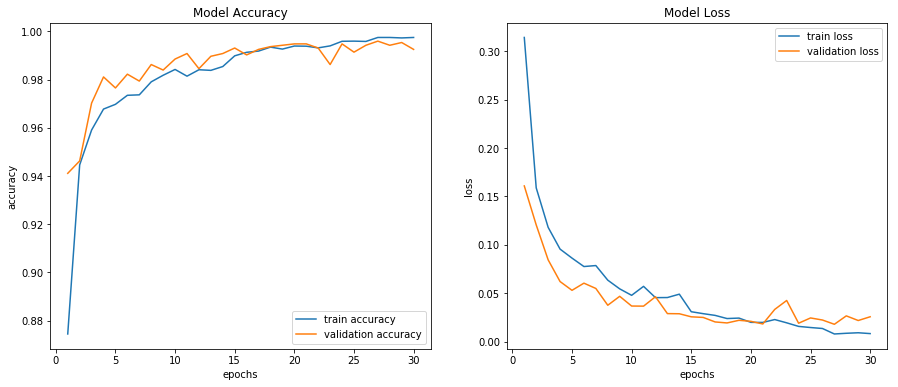

In [43]:
visual(cnn_history)

**Prepare for submission**

In [44]:
test_pred = cnn.predict_classes(test_images)

In [45]:
test_df['has_cactus'] = np.squeeze(test_pred)

In [46]:
test_df.head()

,id,has_cactus,path,images
0,000940378805c44108d287872b2f04ce.jpg,1,../input/test/test/000940378805c44108d287872b2...,"[[[0.2235294117647059, 0.23137254901960785, 0...."
1,0017242f54ececa4512b4d7937d1e21e.jpg,1,../input/test/test/0017242f54ececa4512b4d7937d...,"[[[0.3137254901960784, 0.2784313725490196, 0.2..."
2,001ee6d8564003107853118ab87df407.jpg,0,../input/test/test/001ee6d8564003107853118ab87...,"[[[0.3803921568627451, 0.3607843137254902, 0.2..."
3,002e175c3c1e060769475f52182583d0.jpg,0,../input/test/test/002e175c3c1e060769475f52182...,"[[[0.4392156862745098, 0.3843137254901961, 0.3..."
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1,../input/test/test/0036e44a7e8f7218e9bc7bf8137...,"[[[0.3411764705882353, 0.3137254901960784, 0.3..."


In [47]:
submission_df = test_df[['id','has_cactus']]

In [48]:
submission_df.to_csv('cactus_detections.csv', index=False)